# Ollama Qwen3 Agent with LangGraph and LangChain

In [1]:
%pip install -U --upgrade pip langchain_ollama mcp langchain-mcp-adapters

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain.tools import tool
from datetime import datetime
from typing import TypedDict, Annotated, Sequence
import operator


In [3]:
from langfuse.callback import CallbackHandler
# load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()


# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler() 

In [4]:

# # Define tool to get current system time
# @tool
# def get_current_time():
#     """Returns current system time in YYYY-MM-DD HH:MM:SS format."""
#     return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


In [23]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # Make sure to update to the full absolute path to your math_server.py file
            "args": ["/home/daimler/workspaces/agents-course-huggingface/langagent/tools/mcp-srv.py"],
            "transport": "stdio",
        },
        # "weather": {
        #     # make sure you start your weather server on port 8000
        #     "url": "http://localhost:8000/mcp/",
        #     "transport": "streamable_http",
        # }
    }
)
tools = await client.get_tools()

In [ ]:
from langchain_ollama import ChatOllama

# Define graph state
class AgentState(TypedDict):
    messages: Annotated[Sequence, operator.add]  # List of conversation messages
    next_agent: str  # Indicates next agent to execute

# Initialize local language models with Ollama
manager_llm = ChatOllama(
    model="qwen3",
    # temperature=0,  # Deterministic mode for deep reasoning
    # num_predict=100  # Increased reasoning capacity
)

operator_llm = ChatOllama(
    model="qwen3",
    reasoning=False,
    # temperature=0,  # No deep reasoning
    # num_predict=50  # More concise responses
)

# Prompts for agents
MANAGER_PROMPT = PromptTemplate.from_template("""
You are a Manager Agent specialized in coordinating tasks between other agents.
Your current task is to obtain the system time by requesting help from the Operator Agent.

Instructions:
1. Analyze the request deeply and determine you need the Operator Agent
2. Formulate a clear request to obtain the system time
3. Once received, present the final response

Conversation history:
{history}

User request: {input}

Response:
""")

OPERATOR_PROMPT = PromptTemplate.from_template("""
You are an Operator Agent responsible for executing specific tasks.
Your current task is to provide the system time using your specialized tool.

Instructions:
1. Use the get_current_time() function when requesting system time
2. Return only the function result without additional explanations
3. /no_think

Request: {input}

Response:
""")

# Functions for graph nodes
def manager_node(state):
    # Process previous messages
    history = "\n".join([msg.content for msg in state["messages"][-5:]])
    user_input = "Get system time"
    
    # Generate manager response
    prompt = MANAGER_PROMPT.format(history=history, input=user_input)
    response = manager_llm.invoke(prompt)
    
    # Update state
    new_messages = [
        AIMessage(content=f"[Manager]: {response.content}"),
        HumanMessage(content="[Manager->Operator]: I need to know the system time")
    ]
    
    return {
        "messages": new_messages,
        "next_agent": "operator"
    }

def operator_node(state):
    # Extract request from history
    last_message = state["messages"][-1].content
    
    # Execute tool using invoke with empty input
    # current_time = get_current_time.invoke("")
    
    # Create structured response
    # tool_response = f"[Tool Response]: {current_time}"
    tool_response = operator_llm.bind_tools(tools).invoke(state["messages"])
    operator_response = operator_llm.invoke(f"Request: /no_think {last_message}\n\n{tool_response}")
    # Update state
    new_messages = [
        AIMessage(content=f"[Operator]: {operator_response.content}"),
        HumanMessage(content="[Operator->Manager]: I have obtained the system time")
    ]
    
    return {
        "messages": new_messages,
        "next_agent": "end"
    }


In [25]:

from langgraph.prebuilt import ToolNode, tools_condition

# Configure graph using LangGraph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("manager", manager_node)
workflow.add_node("operator", operator_node)
workflow.add_node(ToolNode(tools))

# Set entry point
workflow.set_entry_point("manager")

# Configure conditional flow
def router(state):
    return state["next_agent"]

workflow.add_conditional_edges(
    "manager",
    router,
    {
        "operator": "operator",
        "end": END
    }
)

workflow.add_conditional_edges(
    "operator",
    router,
    {
        "end": END
    }
)
# workflow.add_conditional_edges(
#     "operator",
#     tools_condition,
# )

workflow.add_edge("tools", "operator")
# Compile graph
app = workflow.compile()


In [27]:
# Execute full workflow
final_state = app.invoke({
    "messages": [HumanMessage(content="Get system time")],
    "next_agent": "manager"
}, config={"callbacks": [langfuse_handler]})

# Display results
print("\nComplete conversation:")
for msg in final_state["messages"]:
    if isinstance(msg, AIMessage):
        print(f"{msg.content}")




Complete conversation:
[Manager]: <think>
Okay, the user wants the system time. I need to coordinate with the Operator Agent. Let me check the instructions again. First, I have to determine that I need the Operator Agent. Since the user is asking for the system time, which is likely something the Operator Agent can provide directly, that's the right agent to contact.

Next, I need to formulate a clear request. The user's request is straightforward, so I should ask the Operator Agent to provide the current system time. I should make sure the request is specific and unambiguous. Maybe something like, "Operator Agent, could you please provide the current system time?"

Once I get the time from the Operator Agent, I'll present it to the user as the final response. Let me make sure there are no other steps or agents involved here. The user's request is direct, so there's no need for additional steps beyond getting the time from the Operator Agent. Alright, that's all. Let's proceed with th

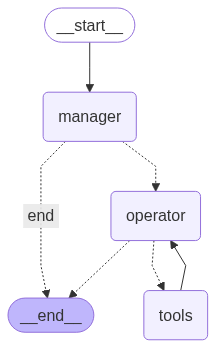

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))